In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:

import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

## Create Label Variable

In [3]:
labels = os.listdir(r"/content/drive/MyDrive/Eye_Classification/data")

In [4]:
labels
#Show label and create labels variable

['Closed', 'Open', 'yawn', 'no_yawn']

## Show a random image

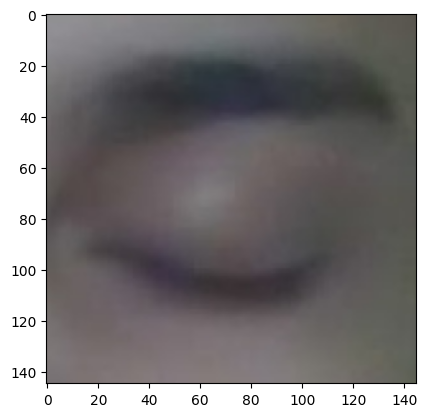

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"/content/drive/MyDrive/Eye_Classification/data/Closed/_3.jpg"))

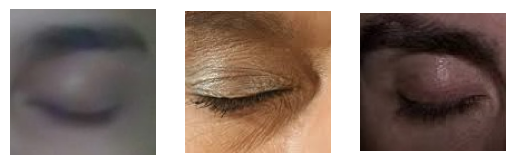

In [ ]:


# Load and display multiple images
image_paths = [r"/content/drive/MyDrive/Eye_Classification/data/Closed/_3.jpg", r"/content/drive/MyDrive/Eye_Classification/data/Closed/_10.jpg",r"/content/drive/MyDrive/Eye_Classification/data/Closed/_20.jpg"]

num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images)

for i, image_path in enumerate(image_paths):
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## Create a and show Image array

In [7]:
a = plt.imread(r"/content/drive/MyDrive/Eye_Classification/data/yawn/10.jpg")

## Image shape

In [8]:
a.shape

(480, 640, 3)

## Display the image of a yawning face without the background, using the array representation of the face image.


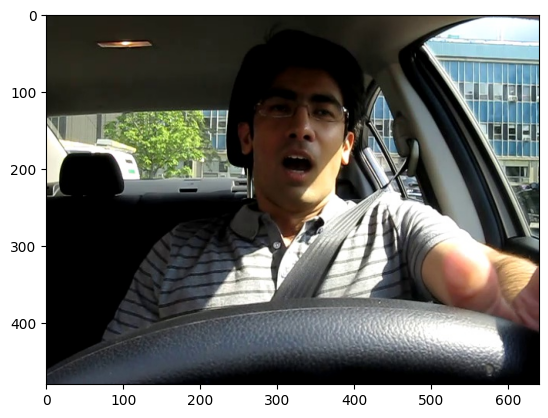

In [ ]:
plt.imshow(plt.imread(r"/content/drive/MyDrive/Eye_Classification/data/yawn/59.jpg"))

## Extract only the face region from both yawn and not_yawn images.

In [13]:
def face_for_yawn(direc=r"/content/drive/MyDrive/Eye_Classification/data", face_cas_path=r"/content/drive/MyDrive/Eye_Classification/haarcascade/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            try:
                image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array, class_num1])
            except Exception as e:
                print(f"Error processing image {image}: {e}")

    return yaw_no

## For Closed and Open eye

In [14]:
def get_data(dir_path=r"/content/drive/MyDrive/Eye_Classification/data"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label) + 2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(f"Error processing image {img}: {e}")

    return data

## Expand the dataset by adding more data and convert the data into an array format.

In [15]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)

    # Ensure all images and labels are correctly formatted
    images = []
    labels = []

    for item in yaw_no:
        images.append(item[0])
        labels.append(item[1])

    return np.array(images), np.array(labels)

## New variable to store

In [16]:
new_images, new_labels = append_data()
print("Data shape:", new_images.shape, new_labels.shape)

0
1
2
3
Data shape: (1690, 145, 145, 3) (1690,)


## Separate the labels and features in the dataset

## Reshape images X

In [17]:
X = np.array(new_images)
X = X.reshape(-1, 145, 145, 3)

In [19]:
X.shape

(1690, 145, 145, 3)

## Perform label binarization.

In [20]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(new_labels)

## Label array

In [21]:
y = np.array(y)

In [22]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]])

## Train Test split

In [23]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [24]:
len(X_test)

507

## Import some dependencies

In [26]:
from tensorflow.python.keras.layers import Lambda, Dropout
from tensorflow.python.keras.layers.advanced_activations import ELU, LeakyReLU, ReLU
from tensorflow.python.keras import activations
from keras import callbacks, layers, metrics, regularizers
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation,SimpleRNN
import cv2
import os
import numpy as np
import pandas as pd
import pickle


## Data Augmentation

In [27]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Build and train CNN model

In [28]:
model_CNN = keras.models.Sequential()

model_CNN.add(Conv2D(filters= 256, kernel_size=(3, 3), activation="relu", input_shape=(145,145,3)))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 128, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 64, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(Conv2D(filters= 32, kernel_size= (3, 3), activation="relu",kernel_initializer='he_normal'))
model_CNN.add(BatchNormalization())
model_CNN.add(MaxPooling2D(pool_size=(2, 2)))

model_CNN.add(keras.layers.Flatten())
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.5))

model_CNN.add(keras.layers.Dense(64, activation="relu"))
model_CNN.add(keras.layers.Dense(4, activation="softmax"))

model_CNN.build(input_shape=(None, 145, 145, 3))
model_CNN.summary()

model_CNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 batch_normalization (Batch  (None, 143, 143, 256)     1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 batch_normalization_1 (Bat  (None, 69, 69, 128)       512       
 chNormalization)                                                
                                                        

In [29]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [30]:
history_CNN = model_CNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

Epoch 1/50
37/37 [==============================] - 29s 403ms/step - loss: 0.8127 - accuracy: 0.7278 - val_loss: 0.9749 - val_accuracy: 0.5720


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
37/37 [==============================] - 8s 212ms/step - loss: 0.4601 - accuracy: 0.8487 - val_loss: 1.1237 - val_accuracy: 0.4753
Epoch 3/50
37/37 [==============================] - 8s 209ms/step - loss: 0.4220 - accuracy: 0.8478 - val_loss: 1.0481 - val_accuracy: 0.5306
Epoch 4/50
37/37 [==============================] - 10s 265ms/step - loss: 0.4113 - accuracy: 0.8614 - val_loss: 1.1093 - val_accuracy: 0.4872
Epoch 5/50
37/37 [==============================] - 11s 292ms/step - loss: 0.2927 - accuracy: 0.8867 - val_loss: 2.8045 - val_accuracy: 0.4241
Epoch 6/50
37/37 [==============================] - 8s 225ms/step - loss: 0.3370 - accuracy: 0.8817 - val_loss: 1.5117 - val_accuracy: 0.5602
Epoch 7/50
37/37 [==============================] - 15s 402ms/step - loss: 0.2596 - accuracy: 0.9019 - val_loss: 1.2061 - val_accuracy: 0.6134
Epoch 8/50
37/37 [==============================] - 18s 482ms/step - loss: 0.2610 - accuracy: 0.9028 - val_loss: 0.6485 - val_accuracy: 0.7160
Ep

In [31]:
model_CNN.save('/content/drive/MyDrive/Eye_Classification/history_and_model/last_model_CNN.h5')
with open('/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN.history, file_pi)

# Build and train CNN-RNN model

In [68]:
import keras
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, SimpleRNN, Flatten, Dropout, Dense, Reshape

model_CNN_RNN = keras.models.Sequential()

# Initial Conv2D layer to extract initial spatial features
model_CNN_RNN.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu", input_shape=(145, 145, 3)))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Another Conv2D layer before transitioning to RNN
model_CNN_RNN.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu", kernel_initializer='he_normal'))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(MaxPooling2D(pool_size=(2, 2)))

# Reshape the output to be suitable for RNN input
model_CNN_RNN.add(Reshape((34, 34 * 128)))

# Adding SimpleRNN layers
model_CNN_RNN.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(SimpleRNN(32, activation='relu'))
model_CNN_RNN.add(BatchNormalization())

# Flatten and add Dense layers
model_CNN_RNN.add(Flatten())
model_CNN_RNN.add(BatchNormalization())
model_CNN_RNN.add(Dropout(0.5))

model_CNN_RNN.add(Dense(64, activation="relu"))
model_CNN_RNN.add(Dense(4, activation="softmax"))

model_CNN_RNN.build(input_shape=(None, 145, 145, 3))
model_CNN_RNN.summary()

model_CNN_RNN.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 batch_normalization_12 (Ba  (None, 143, 143, 256)     1024      
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 71, 71, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 batch_normalization_13 (Ba  (None, 69, 69, 128)       512       
 tchNormalization)                                               
                                                      

In [69]:
# Add Callback
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', mode='min', patience=5, verbose=1)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [mcp_save]

In [70]:
history_CNN_RNN = model_CNN_RNN.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator), callbacks=callbacks)

Epoch 1/50
37/37 [==============================] - 19s 348ms/step - loss: 1.3969 - accuracy: 0.3829 - val_loss: 1.3467 - val_accuracy: 0.4241


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
37/37 [==============================] - 19s 509ms/step - loss: 1.0465 - accuracy: 0.5317 - val_loss: 1.3624 - val_accuracy: 0.4300
Epoch 3/50
37/37 [==============================] - 12s 311ms/step - loss: 0.8717 - accuracy: 0.6061 - val_loss: 1.3501 - val_accuracy: 0.4241
Epoch 4/50
37/37 [==============================] - 11s 291ms/step - loss: 0.6828 - accuracy: 0.7219 - val_loss: 0.9703 - val_accuracy: 0.5187
Epoch 5/50
37/37 [==============================] - 13s 337ms/step - loss: 0.5330 - accuracy: 0.7802 - val_loss: 0.9074 - val_accuracy: 0.5996
Epoch 6/50
37/37 [==============================] - 12s 313ms/step - loss: 0.4821 - accuracy: 0.8166 - val_loss: 1.0523 - val_accuracy: 0.5602
Epoch 7/50
37/37 [==============================] - 11s 306ms/step - loss: 0.4274 - accuracy: 0.8453 - val_loss: 0.6970 - val_accuracy: 0.7357
Epoch 8/50
37/37 [==============================] - 10s 256ms/step - loss: 0.4088 - accuracy: 0.8428 - val_loss: 0.7654 - val_accuracy: 0.6489

In [71]:
model_CNN_RNN.save('/content/drive/MyDrive/Eye_Classification/history_and_model/last_model_CNN_RNN.h5')
with open('/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN_RNN.pkl', 'wb') as file_pi:
    pickle.dump(history_CNN_RNN.history, file_pi)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Comparision

In [72]:
from keras.models import load_model

best_model_CNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN.h5")
best_model_CNN_RNN = load_model("/content/drive/MyDrive/Eye_Classification/history_and_model/best_model_CNN_RNN.h5")

history_path_CNN = "/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN.pkl"
history_path_CNN_RNN = "/content/drive/MyDrive/Eye_Classification/history_and_model/history_CNN_RNN.pkl"

with open(history_path_CNN, 'rb') as file:
    history_CNN = pickle.load(file)
with open(history_path_CNN_RNN, 'rb') as file:
    history_CNN_RNN = pickle.load(file)

## Comapare accuracy and loss on train and val set

CNN Training Accuracy:  [0.7278106212615967, 0.8486897945404053, 0.8478444814682007, 0.8613693714141846, 0.8867286443710327, 0.88165682554245, 0.9019442200660706, 0.9027895331382751, 0.9087066650390625, 0.9129332304000854, 0.9112426042556763, 0.9247675538063049, 0.9087066650390625, 0.9357565641403198, 0.9196956753730774, 0.9281487464904785, 0.939983069896698, 0.9340659379959106, 0.9289940595626831, 0.9357565641403198, 0.944209635257721, 0.937447190284729, 0.9408283829689026, 0.9433643221855164, 0.9391377568244934, 0.9518173933029175, 0.9382925033569336, 0.956889271736145, 0.9560439586639404, 0.9535080194473267, 0.9450549483299255, 0.9551986455917358, 0.9628064036369324, 0.963651716709137, 0.9644970297813416, 0.9653423428535461, 0.9653423428535461, 0.9653423428535461, 0.9602705240249634, 0.9695689082145691, 0.9653423428535461, 0.9628064036369324, 0.9695689082145691, 0.9611157774925232, 0.9661876559257507, 0.9712595343589783, 0.9687235951423645, 0.9695689082145691, 0.963651716709137, 0.9

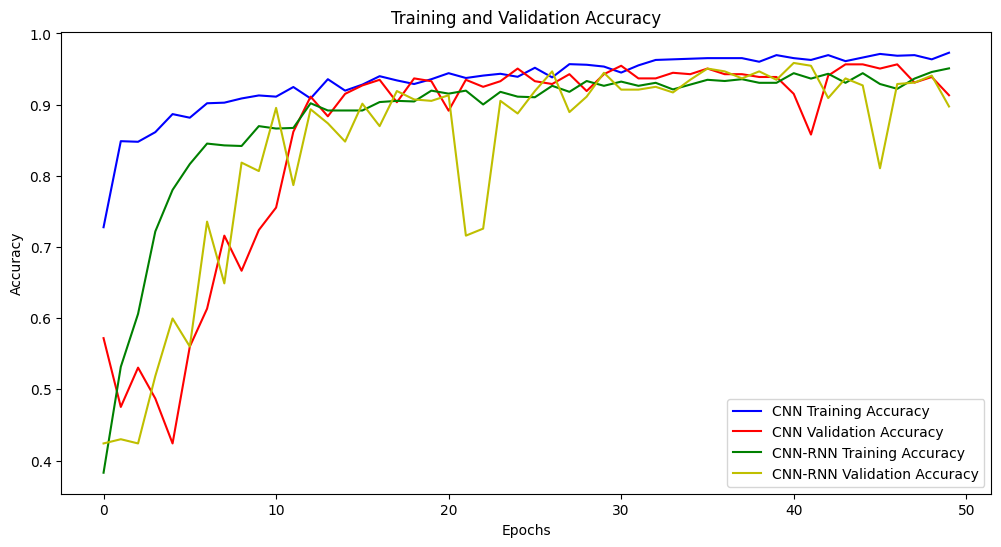

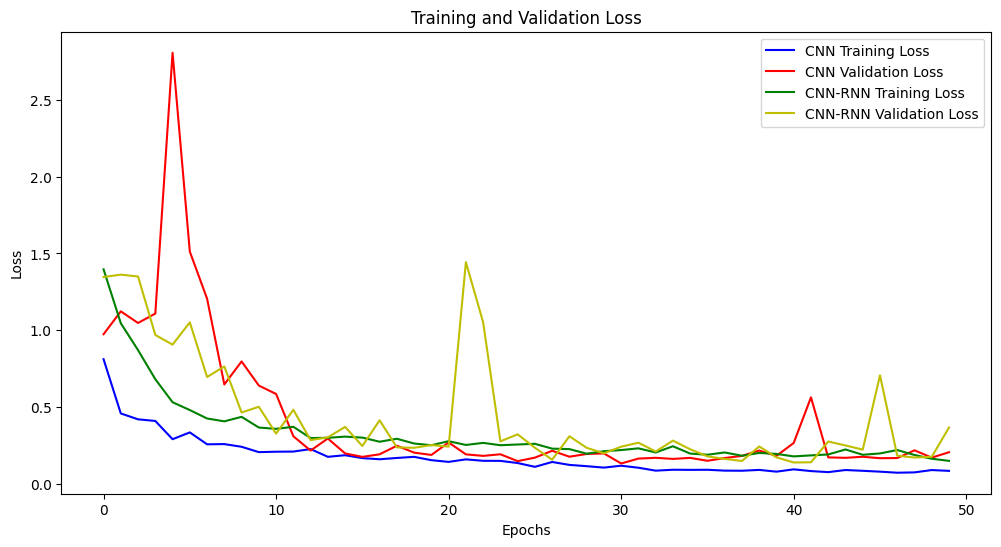

In [73]:
import matplotlib.pyplot as plt

# Extract metrics from history
accuracy_CNN = history_CNN['accuracy']
val_accuracy_CNN = history_CNN['val_accuracy']
loss_CNN = history_CNN['loss']
val_loss_CNN = history_CNN['val_loss']

accuracy_CNN_RNN = history_CNN_RNN['accuracy']
val_accuracy_CNN_RNN = history_CNN_RNN['val_accuracy']
loss_CNN_RNN = history_CNN_RNN['loss']
val_loss_CNN_RNN = history_CNN_RNN['val_loss']

# Debug prints to verify lengths and data
print("CNN Training Accuracy: ", accuracy_CNN)
print("CNN Validation Accuracy: ", val_accuracy_CNN)
print("CNN Training Loss: ", loss_CNN)
print("CNN Validation Loss: ", val_loss_CNN)

print("CNN-RNN Training Accuracy: ", accuracy_CNN_RNN)
print("CNN-RNN Validation Accuracy: ", val_accuracy_CNN_RNN)
print("CNN-RNN Training Loss: ", loss_CNN_RNN)
print("CNN-RNN Validation Loss: ", val_loss_CNN_RNN)

epochs_CNN = list(range(len(accuracy_CNN)))
epochs_CNN_RNN = list(range(len(accuracy_CNN_RNN)))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, accuracy_CNN, "b", label="CNN Training Accuracy")
plt.plot(epochs_CNN, val_accuracy_CNN, "r", label="CNN Validation Accuracy")
plt.plot(epochs_CNN_RNN, accuracy_CNN_RNN, "g", label="CNN-RNN Training Accuracy")
plt.plot(epochs_CNN_RNN, val_accuracy_CNN_RNN, "y", label="CNN-RNN Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_CNN, loss_CNN, "b", label="CNN Training Loss")
plt.plot(epochs_CNN, val_loss_CNN, "r", label="CNN Validation Loss")
plt.plot(epochs_CNN_RNN, loss_CNN_RNN, "g", label="CNN-RNN Training Loss")
plt.plot(epochs_CNN_RNN, val_loss_CNN_RNN, "y", label="CNN-RNN Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# classification report

In [47]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [48]:
# Make predictions
predictions_CNN = best_model_CNN.predict(X_test)
predictions_CNN_RNN = best_model_CNN_RNN.predict(X_test)

# Convert predictions to label indices
predicted_classes_CNN = np.argmax(predictions_CNN, axis=1)
predicted_classes_CNN_RNN = np.argmax(predictions_CNN_RNN, axis=1)

16/16 [==============================] - 1s 30ms/step


In [55]:
from sklearn.metrics import classification_report
# Classification report for CNN
print("Classification Report for CNN:\n")
report_CNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN, target_names=labels_new)
print(report_CNN)

# Classification report for CNN-RNN
print("Classification Report for CNN-RNN:\n")
report_CNN_RNN = classification_report(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN, target_names=labels_new)
print(report_CNN_RNN)

Classification Report for CNN:

              precision    recall  f1-score   support

        yawn       0.13      1.00      0.23        63
     no_yawn       0.00      0.00      0.00        74
      Closed       1.00      0.00      0.01       215
        Open       1.00      0.14      0.24       155

    accuracy                           0.17       507
   macro avg       0.53      0.29      0.12       507
weighted avg       0.75      0.17      0.11       507

Classification Report for CNN-RNN:

              precision    recall  f1-score   support

        yawn       0.68      0.65      0.67        63
     no_yawn       0.67      0.86      0.76        74
      Closed       0.59      0.96      0.73       215
        Open       1.00      0.01      0.01       155

    accuracy                           0.62       507
   macro avg       0.74      0.62      0.54       507
weighted avg       0.74      0.62      0.51       507



## Confusion matrix

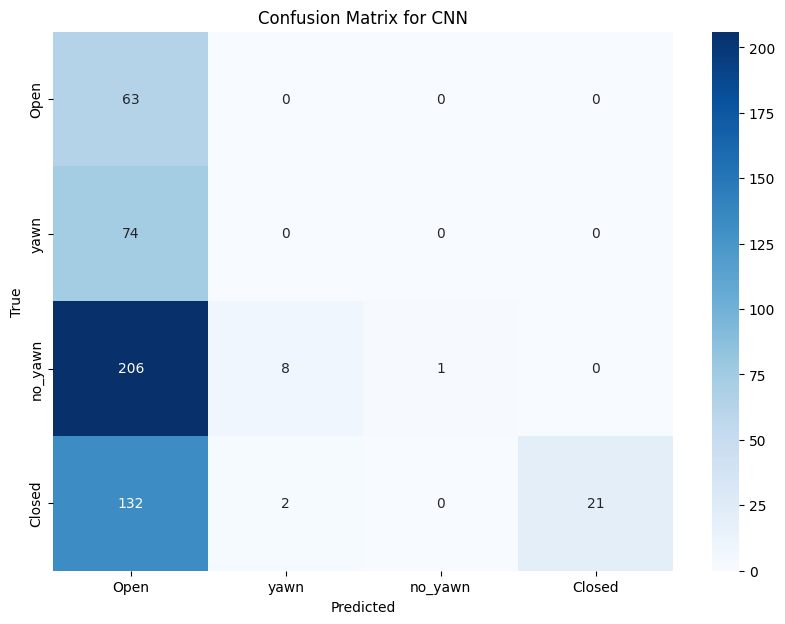

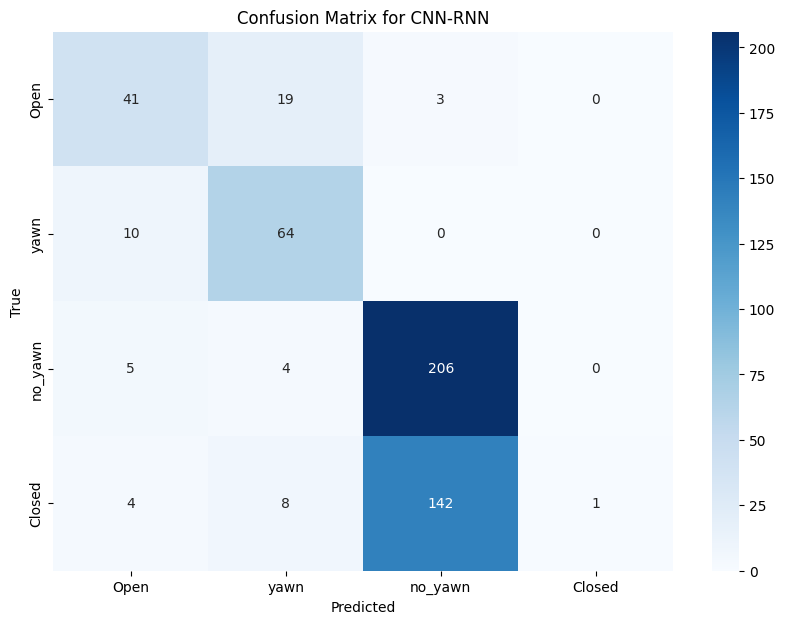

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrices
cm_CNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN)
cm_CNN_RNN = confusion_matrix(np.argmax(y_test, axis=1), predicted_classes_CNN_RNN)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, labels_new):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_new, yticklabels=labels_new)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Define class labels
labels_new = [ "Open","yawn", "no_yawn", "Closed",]

# Plot confusion matrices
plot_confusion_matrix(cm_CNN, "Confusion Matrix for CNN", labels_new)
plot_confusion_matrix(cm_CNN_RNN, "Confusion Matrix for CNN-RNN", labels_new)


# predicting function

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    try:
        img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
        img_array = img_array / 255
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    except Exception as e:
        print("Error occurred while reading the image file:", e)
        return None

model = tf.keras.models.load_model("./drowiness_new2.h5")

# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [ ]:
prediction = model.predict([prepare(r"data\train\Closed\_100.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 239ms/step


2

In [ ]:
prediction = model.predict([prepare(r"data\train\Closed\_120.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 112ms/step


2

In [ ]:
prediction = model.predict([prepare(r"data\train\yawn\12.jpg")])
np.argmax(prediction)


1/1 [==============================] - 0s 144ms/step


3